## 1. Importations et configuration
Chargement des bibliothèques utilisées pour la manipulation, l'analyse et la visualisation.

In [3]:
import re
from typing import Iterable, Optional
import pandas as pd
import numpy as np
from pandas.api.types import is_string_dtype, is_numeric_dtype
import seaborn as sns
import matplotlib.pyplot as plt
from textwrap import wrap
import unicodedata

## 2. Chargement des données DVF brutes
Lecture du fichier texte DVF séparé par `|`.

In [4]:
import pandas as pd
df = pd.read_csv("ValeursFoncieres-2025-S1.txt", sep="|")
print(df.shape)
df.head()


/tmp/ipykernel_7465/482645561.py:2: DtypeWarning: Columns (18,23,24,26,28,29,31,33) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("ValeursFoncieres-2025-S1.txt", sep="|")


(1387077, 43)


,Identifiant de document,Reference document,1 Articles CGI,2 Articles CGI,3 Articles CGI,4 Articles CGI,5 Articles CGI,No disposition,Date mutation,Nature mutation,...,Surface Carrez du 5eme lot,Nombre de lots,Code type local,Type local,Identifiant local,Surface reelle bati,Nombre pieces principales,Nature culture,Nature culture speciale,Surface terrain
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,07/01/2025,Vente,...,NaN,0,NaN,NaN,NaN,NaN,NaN,J,NaN,78.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,07/01/2025,Vente,...,NaN,0,1.0,Maison,NaN,111.0,5.0,S,NaN,133.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,07/01/2025,Vente,...,NaN,0,3.0,Dépendance,NaN,0.0,0.0,S,NaN,133.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,06/01/2025,Vente,...,NaN,0,NaN,NaN,NaN,NaN,NaN,S,NaN,46.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,06/01/2025,Vente,...,NaN,0,NaN,NaN,NaN,NaN,NaN,J,NaN,17.0


## 3. Synthèse du jeu de données initial
Résumé des colonnes: type, nombre de NaN et proportion de valeurs manquantes (avec placeholders).

In [5]:
# Print: column name, dtype, and number of NaN values (with placeholder handling)
def summarize_dataframe(df, include_placeholders: bool = True, extra_placeholders=None, show_percent: bool = True):
    placeholders = {'', 'na', 'nan', 'n/a', 'none', 'null', '-'}
    if extra_placeholders:
        placeholders |= {str(x).strip().lower() for x in extra_placeholders}

    cols = list(df.columns)
    dtypes = df.dtypes.astype(str)
    n_rows = df.shape[0]

    n_nan_true_list = []
    n_missing_list = []
    for c in cols:
        s = df[c]
        # true NaN count
        n_true = int(s.isna().sum())
        if include_placeholders and pd.api.types.is_string_dtype(s):
            # Normalize strings: replace NBSP, strip, lowercase
            sn = s.astype(str).str.replace(' ', ' ', regex=False).str.strip().str.lower()
            m_place = sn.eq('') | sn.isin(placeholders)
            m_missing = s.isna() | m_place
            n_all = int(m_missing.sum())
        else:
            n_all = n_true
        n_nan_true_list.append(n_true)
        n_missing_list.append(n_all)

    n_non_missing = [n_rows - x for x in n_missing_list]
    data = {
        'column': cols,
        'dtype': [dtypes[c] for c in cols],
        'n_nan_true': n_nan_true_list,
        'n_missing': n_missing_list,
        'n_non_missing': n_non_missing,
    }
    if show_percent:
        import numpy as np
        data['pct_missing'] = (np.array(n_missing_list) / max(n_rows, 1) * 100).round(2)

    summary_df = pd.DataFrame(data)
    print(summary_df.to_string(index=False))

summarize_dataframe(df)

                    column   dtype  n_nan_true  n_missing  n_non_missing  pct_missing
   Identifiant de document float64     1387077    1387077              0       100.00
        Reference document float64     1387077    1387077              0       100.00
            1 Articles CGI float64     1387077    1387077              0       100.00
            2 Articles CGI float64     1387077    1387077              0       100.00
            3 Articles CGI float64     1387077    1387077              0       100.00
            4 Articles CGI float64     1387077    1387077              0       100.00
            5 Articles CGI float64     1387077    1387077              0       100.00
            No disposition   int64           0          0        1387077         0.00
             Date mutation  object           0          0        1387077         0.00
           Nature mutation  object           0          0        1387077         0.00
           Valeur fonciere  object       13995      13

## 4. Filtrer la commune de Grenoble (INSEE 38185)
Filtrage par Code département = 38 et Code commune = 185.

In [6]:
# Garde uniquement la commune de Grenoble via (Code departement=38, Code commune=185)
grenoble_code = '185'  # Code commune pour Grenoble dans le département 38
df_grenoble = df[(df['Code departement'].astype(str) == '38') 
                  & (df['Code commune'].apply(lambda x: f"{int(x):03d}" if pd.notna(x) else None) == grenoble_code)].copy()
print('Grenoble shape:', df_grenoble.shape)
df_grenoble.head()

Grenoble shape: (2710, 43)


,Identifiant de document,Reference document,1 Articles CGI,2 Articles CGI,3 Articles CGI,4 Articles CGI,5 Articles CGI,No disposition,Date mutation,Nature mutation,...,Surface Carrez du 5eme lot,Nombre de lots,Code type local,Type local,Identifiant local,Surface reelle bati,Nombre pieces principales,Nature culture,Nature culture speciale,Surface terrain
538293,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,10/01/2025,Vente,...,NaN,2,2.0,Appartement,NaN,45.0,2.0,NaN,NaN,NaN
538294,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,10/01/2025,Vente,...,NaN,2,3.0,Dépendance,NaN,0.0,0.0,NaN,NaN,NaN
538297,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,08/01/2025,Vente,...,NaN,2,3.0,Dépendance,NaN,0.0,0.0,NaN,NaN,NaN
538298,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,08/01/2025,Vente,...,NaN,2,2.0,Appartement,NaN,29.0,1.0,NaN,NaN,NaN
538299,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,09/01/2025,Vente,...,NaN,1,4.0,Local industriel. commercial ou assimilé,NaN,12.0,0.0,NaN,NaN,NaN


## 5. Synthèse des données filtrées
Résumé des colonnes après filtrage sur Grenoble.

In [7]:
summarize_dataframe(df_grenoble)

                    column   dtype  n_nan_true  n_missing  n_non_missing  pct_missing
   Identifiant de document float64        2710       2710              0       100.00
        Reference document float64        2710       2710              0       100.00
            1 Articles CGI float64        2710       2710              0       100.00
            2 Articles CGI float64        2710       2710              0       100.00
            3 Articles CGI float64        2710       2710              0       100.00
            4 Articles CGI float64        2710       2710              0       100.00
            5 Articles CGI float64        2710       2710              0       100.00
            No disposition   int64           0          0           2710         0.00
             Date mutation  object           0          0           2710         0.00
           Nature mutation  object           0          0           2710         0.00
           Valeur fonciere  object           2        

## 6. Construction du sous-ensemble des ventes (df_grenoble_vente) — utilitaires
Fonctions d'aide pour normaliser les noms de colonnes et convertir les types.

In [8]:
# Corrected/robust cell to build df_grenoble_vente with safe parsing and filtering


# --- Helpers ---------------------------------------------------------------
def _normalize(s: str) -> str:
    """lowercase, strip, remove accents/diacritics, collapse spaces."""
    if s is None:
        return ""
    import unicodedata
    s2 = unicodedata.normalize("NFKD", str(s))
    s2 = "".join(ch for ch in s2 if not unicodedata.combining(ch))
    return re.sub(r"\s+", " ", s2).strip().lower()

def _first_present(candidates: Iterable[str], cols: Iterable[str]) -> Optional[str]:
    """Return first matching column name, matching after normalization."""
    norm_map = {_normalize(c): c for c in cols}
    for cand in candidates:
        n = _normalize(cand)
        if n in norm_map:
            return norm_map[n]
    return None

def _to_numeric(series: pd.Series) -> pd.Series:
    """Robust numeric conversion (handles commas, spaces, €)."""
    if is_numeric_dtype(series):
        return series
    s = series.astype(str).str.replace(" ", " ", regex=False)  # nbsp -> space
    s = s.str.replace(r"[^\d,.]", "", regex=True).str.replace(",", ".", regex=False)
    return pd.to_numeric(s, errors="coerce")

def _code_commune_isere_grenoble(df: pd.DataFrame) -> pd.Series:
    """Match Grenoble via codes: departement '38' and code commune '185' (INSEE 38185)."""
    if 'Code departement' in df.columns and 'Code commune' in df.columns:
        dep = df['Code departement'].astype(str).str.strip()
        # Extract digits from code commune, pad to 3 (handles strings/ints/NaN)
        raw = df['Code commune'].astype(str).str.strip().str.extract(r'(\d+)', expand=False)
        com = raw.fillna('').str.zfill(3)
        return (dep == '38') & (com == '185')
    return pd.Series(False, index=df.index)


### 6.2 Construction de df_grenoble_vente
Sélection des colonnes pertinentes, conversion des types et filtrage sur les mutations de type 'Vente'.

In [9]:
# Rebuild df_grenoble_vente including surface_bati, surface_terrain, and type_local
# Uses earlier helpers if available; defines minimal fallbacks otherwise
try:
    _normalize
except NameError:
    import re
    def _normalize(s: str) -> str:
        if s is None: return ''
        import unicodedata
        s2 = unicodedata.normalize('NFKD', str(s))
        s2 = ''.join(ch for ch in s2 if not unicodedata.combining(ch))
        return re.sub(r'\s+', ' ', s2).strip().lower()
try:
    _to_numeric
except NameError:
    def _to_numeric(series):
        s = series.astype(str).str.replace(' ', ' ', regex=False)
        s = s.str.replace(r'[^\d,.-]', '', regex=True).str.replace(',', '.', regex=False)
        return pd.to_numeric(s, errors='coerce')
def _first_present(cands, cols):
    norm_map = {_normalize(c): c for c in cols}
    for cand in cands:
        n = _normalize(cand)
        if n in norm_map:
            return norm_map[n]
    return None
def _code_commune_isere_grenoble(df_):
    if 'Code departement' in df_.columns and 'Code commune' in df_.columns:
        dep = df_['Code departement'].astype(str).str.strip()
        raw = df_['Code commune'].astype(str).str.strip().str.extract(r'(\d+)', expand=False)
        com = raw.fillna('').str.zfill(3)
        return (dep == '38') & (com == '185')
    return pd.Series(False, index=df_.index)
colmap = {
    'price':           ['Valeur fonciere', 'valeur fonciere', 'valeur_fonciere'],
    'type_local':      ['Type local', 'type_local', 'Type_local', 'TYPE_LOCAL', 'TYPE LOCAL', 'type local'],
    'surface_bati':    ['Surface reelle bati', 'Surface reelle bâti', 'surface reelle bati', 'surface_reelle_bati'],
    'surface_terrain': ['Surface terrain', 'surface terrain', 'surface_terrain'],
    'date':            ['Date mutation', 'date mutation', 'date_mutation'],
    'nb':              ['Nombre pieces principales', 'Nombre pièces principales', 'nombre pieces principales', 'nombre_pieces_principales'],
    'nature':          ['Nature mutation', 'nature mutation', 'nature_mutation'],
    'commune':         ['Commune', 'commune'],
}
cols = list(df.columns)
price_col        = _first_present(colmap['price'], cols)
bati_col         = _first_present(colmap['surface_bati'], cols)
terrain_col      = _first_present(colmap['surface_terrain'], cols)
date_col         = _first_present(colmap['date'], cols)
nb_col           = _first_present(colmap['nb'], cols)
nature_col       = _first_present(colmap['nature'], cols)
commune_col      = _first_present(colmap['commune'], cols)
type_local_col   = _first_present(colmap['type_local'], cols)
base = df_grenoble.copy() if 'df_grenoble' in globals() else df.copy()
if 'df_grenoble' not in globals():
    if commune_col is not None:
        mask_commune = base[commune_col].astype(str).map(_normalize).eq('grenoble')
        base = base.loc[mask_commune].copy()
    else:
        mask_codes = _code_commune_isere_grenoble(base)
        base = base.loc[mask_codes].copy()
if nature_col is not None:
    mask_vente = base[nature_col].astype(str).map(_normalize).eq('vente')
    base = base.loc[mask_vente].copy()
else:
    print("Alerte: colonne 'Nature mutation' introuvable; aucun filtre 'Vente' appliqué.")
select_cols = [c for c in [price_col, type_local_col,bati_col, terrain_col, date_col, nb_col] if c is not None]
df_grenoble_vente = base.loc[:, select_cols].copy() if select_cols else base.copy()
rename_map = {}
if price_col:      rename_map[price_col]      = 'price'
if bati_col:       rename_map[bati_col]       = 'surface_bati'
if terrain_col:    rename_map[terrain_col]    = 'surface_terrain'
if date_col:       rename_map[date_col]       = 'date'
if nb_col:         rename_map[nb_col]         = 'nb_pieces'
if nature_col:     rename_map[nature_col]     = 'nature'
if commune_col:    rename_map[commune_col]    = 'commune'
if type_local_col: rename_map[type_local_col] = 'type_local'
df_grenoble_vente = df_grenoble_vente.rename(columns=rename_map)
if 'price' in df_grenoble_vente.columns:
    df_grenoble_vente['price'] = _to_numeric(df_grenoble_vente['price'])
if 'surface_bati' in df_grenoble_vente.columns:
    df_grenoble_vente['surface_bati'] = _to_numeric(df_grenoble_vente['surface_bati'])
if 'surface_terrain' in df_grenoble_vente.columns:
    df_grenoble_vente['surface_terrain'] = _to_numeric(df_grenoble_vente['surface_terrain'])
if 'date' in df_grenoble_vente.columns:
    df_grenoble_vente['date'] = pd.to_datetime(df_grenoble_vente['date'], errors='coerce', dayfirst=True)
if 'nb_pieces' in df_grenoble_vente.columns:
    df_grenoble_vente['nb_pieces'] = pd.to_numeric(df_grenoble_vente['nb_pieces'], errors='coerce').astype('Int64')
if 'type_local' in df_grenoble_vente.columns:
    df_grenoble_vente['type_local'] = df_grenoble_vente['type_local'].astype(str).str.strip()
df_grenoble_vente = df_grenoble_vente.reset_index(drop=True)
print('df_grenoble_vente shape:', df_grenoble_vente.shape)
df_grenoble_vente.head()

df_grenoble_vente shape: (2680, 6)


,price,type_local,surface_bati,surface_terrain,date,nb_pieces
0,112560.0,Appartement,45.0,NaN,2025-01-10,2
1,112560.0,Dépendance,0.0,NaN,2025-01-10,0
2,65000.0,Dépendance,0.0,NaN,2025-01-08,0
3,65000.0,Appartement,29.0,NaN,2025-01-08,1
4,9000.0,Local industriel. commercial ou assimilé,12.0,NaN,2025-01-09,0


### 6.3 Diagnostic rapide de df_grenoble_vente
Vérification des valeurs manquantes et des types.

In [10]:
summarize_dataframe(df_grenoble_vente)

         column          dtype  n_nan_true  n_missing  n_non_missing  pct_missing
          price        float64           2          2           2678         0.07
     type_local         object           0         17           2663         0.63
   surface_bati        float64          18         18           2662         0.67
surface_terrain        float64        2503       2503            177        93.40
           date datetime64[ns]           0          0           2680         0.00
      nb_pieces          Int64          18         18           2662         0.67


## 7. Outils génériques d'inspection des valeurs manquantes
Fonctions utilitaires pour localiser et inspecter les NaN par colonne.

In [11]:
# Generic helpers to get rows with NaN for any given DataFrame/column
def _normalize_name(s: str) -> str:
    import re, unicodedata
    s2 = unicodedata.normalize('NFKD', str(s))
    s2 = ''.join(ch for ch in s2 if not unicodedata.combining(ch))
    return re.sub(r'\s+', ' ', s2).strip().lower()

def resolve_column(df_in: pd.DataFrame, name: str, use_normalize: bool = True):
    if name in df_in.columns:
        return name
    if not use_normalize:
        return None
    nmap = {_normalize_name(c): c for c in df_in.columns}
    return nmap.get(_normalize_name(name))

def rows_with_nan(df_in: pd.DataFrame, column_name: str, normalize_name: bool = True) -> pd.DataFrame:
    col = resolve_column(df_in, column_name, use_normalize=normalize_name)
    if col is None:
        print(f"Column '{column_name}' not found. Available: {list(df_in.columns)}")
        return pd.DataFrame(columns=df_in.columns)
    out = df_in[df_in[col].isna()].copy()
    print(f"Rows with NaN in '{col}': {out.shape}")
    return out

# Examples of usage (uncomment as needed):
# df_nan_code_commune = rows_with_nan(df, 'Code commune')
# df_nan_surface_bati = rows_with_nan(df_grenoble_vente, 'surface_bati')
# df_nan_type_local   = rows_with_nan(df_grenoble, 'Type local')

### 7.1 Exemple: lignes avec `surface_bati` manquante

In [12]:
rows_with_nan(df_grenoble_vente, 'surface_bati')

Rows with NaN in 'surface_bati': (18, 6)


,price,type_local,surface_bati,surface_terrain,date,nb_pieces
167,680000.0,Local industriel. commercial ou assimilé,NaN,299.0,2025-01-21,<NA>
170,680000.0,nan,NaN,475.0,2025-01-21,<NA>
443,648000.0,nan,NaN,27.0,2025-02-05,<NA>
444,648000.0,nan,NaN,1155.0,2025-02-05,<NA>
990,6990.0,nan,NaN,NaN,2025-02-26,<NA>
1280,625000.0,nan,NaN,138.0,2025-03-24,<NA>
1335,NaN,nan,NaN,560.0,2025-03-14,<NA>
1336,NaN,nan,NaN,1088.0,2025-03-14,<NA>
1364,221000.0,nan,NaN,105.0,2025-03-20,<NA>
1396,857565.0,nan,NaN,NaN,2025-03-11,<NA>


### 7.2 Rapport détaillé des manquants
Comptage des NaN et placeholders (ex: '', 'NA', 'null').

In [13]:
# Diagnose mismatch between summary NaN counts and rows_with_nan results
def _norm_key(name: str) -> str:
    import re, unicodedata
    s = unicodedata.normalize('NFKD', str(name))
    s = ''.join(ch for ch in s if not unicodedata.combining(ch))
    s = s.lower().replace('_', ' ')
    return re.sub(r'\s+', ' ', s).strip()

def resolve_col(df_in: pd.DataFrame, name: str):
    if name in df_in.columns:
        return name
    nmap = {_norm_key(c): c for c in df_in.columns}
    return nmap.get(_norm_key(name))

def missing_mask(series: pd.Series, include_blanks: bool = True) -> pd.Series:
    m = series.isna()
    if include_blanks:
        s = series.astype(str).str.strip().str.lower()
        placeholders = {'', 'na', 'nan', 'none', 'null'}
        m = m | s.isin(placeholders)
    return m

def report_na(df_in: pd.DataFrame, column_name: str, include_blanks: bool = True) -> pd.DataFrame:
    col = resolve_col(df_in, column_name)
    if col is None:
        print(f"Column '{column_name}' not found. Available: {list(df_in.columns)}")
        return pd.DataFrame(columns=df_in.columns)
    m_true = df_in[col].isna()
    m_all  = missing_mask(df_in[col], include_blanks=include_blanks)
    n_true, n_all = int(m_true.sum()), int(m_all.sum())
    print(f"Column resolved: '{column_name}' -> '{col}'")
    print(f"Rows: {len(df_in)} | isna(): {n_true} | isna()+blanks/placeholders: {n_all}")
    # Show a quick breakdown of placeholder tokens if any
    if n_all > n_true and include_blanks:
        s = df_in.loc[m_all & ~m_true, col].astype(str).str.strip().str.lower()
        print('Placeholder counts:', s.value_counts().to_dict())
    return df_in.loc[m_all].copy()

# Examples (uncomment to debug):
# dbg = report_na(df_grenoble_vente, 'Type local')
# dbg = report_na(df_grenoble_vente, 'type_local')
# dbg = report_na(df, 'Type local')

## 8. Normalisation des placeholders en NaN
Remplace les valeurs vides / 'NA' par de vrais NaN, puis re-synthèse.

In [14]:
# Standardize placeholder strings/blanks to real NaN, then re-summarize

def coerce_placeholders_to_nan(df_in: pd.DataFrame, columns=None, extra_placeholders=None) -> pd.DataFrame:
    df_out = df_in.copy()
    placeholders = {'', 'na', 'nan', 'n/a', 'none', 'null', '-'}
    if extra_placeholders:
        placeholders |= {str(x).strip().lower() for x in extra_placeholders}
    cols = columns if columns is not None else df_out.columns
    for col in cols:
        if col in df_out.columns and is_string_dtype(df_out[col]):
            s = df_out[col].astype(str).str.replace(' ', ' ', regex=False).str.strip()
            mask = s.eq('') | s.str.lower().isin(placeholders)
            df_out.loc[mask, col] = pd.NA
    return df_out

# Example: fix 'type_local' in df_grenoble_vente and show NaN before/after
if 'df_grenoble_vente' in globals() and 'type_local' in df_grenoble_vente.columns:
    before = int(df_grenoble_vente['type_local'].isna().sum())
    df_grenoble_vente = coerce_placeholders_to_nan(df_grenoble_vente, columns=['type_local'])
    after = int(df_grenoble_vente['type_local'].isna().sum())
    print(f"type_local NaN before: {before} -> after: {after}")
    summarize_dataframe(df_grenoble_vente)
else:
    print('df_grenoble_vente/type_local not found; create df_grenoble_vente first.')

type_local NaN before: 0 -> after: 17
         column          dtype  n_nan_true  n_missing  n_non_missing  pct_missing
          price        float64           2          2           2678         0.07
     type_local         object          17         17           2663         0.63
   surface_bati        float64          18         18           2662         0.67
surface_terrain        float64        2503       2503            177        93.40
           date datetime64[ns]           0          0           2680         0.00
      nb_pieces          Int64          18         18           2662         0.67


## 9. Nettoyage final et filtrage des aberrations
Contraintes minimales: suppression des lignes sans prix/type/nb_pieces, remplissage prudent des surfaces, et suppression des surfaces totales très faibles.

In [15]:
# Drop rows with NaN in 'price', 'type_local', or 'nb_pieces';
# fill NaN in 'surface_terrain' and 'surface_bati' with 1 (avoid /0 and log(0));
# drop rows where surface_terrain + surface_bati <= 2 (aberrant tiny/zero area)
if 'df_grenoble_vente' in globals():
    df_grenoble_vente = df_grenoble_vente.copy()

    # Standardize placeholder strings in type_local to real NaN before dropping
    if 'type_local' in df_grenoble_vente.columns:
        s = (df_grenoble_vente['type_local']
             .astype(str)
             .str.replace(' ', ' ', regex=False)  # NBSP -> space
             .str.strip()
             .str.lower())
        placeholders = {'', 'na', 'nan', 'n/a', 'none', 'null', '-'}
        df_grenoble_vente.loc[s.isin(placeholders), 'type_local'] = pd.NA

    # Ensure price and nb_pieces are numeric so non-numeric placeholders are coerced to NaN
    if 'price' in df_grenoble_vente.columns and not pd.api.types.is_numeric_dtype(df_grenoble_vente['price']):
        df_grenoble_vente['price'] = pd.to_numeric(df_grenoble_vente['price'], errors='coerce')
    if 'nb_pieces' in df_grenoble_vente.columns and not pd.api.types.is_numeric_dtype(df_grenoble_vente['nb_pieces']):
        df_grenoble_vente['nb_pieces'] = pd.to_numeric(df_grenoble_vente['nb_pieces'], errors='coerce').astype('Int64')

    # Surfaces: coerce to numeric then fill NaN with 1 (not 0) to avoid /0 or log(0)
    for col in ('surface_terrain', 'surface_bati'):
        if col in df_grenoble_vente.columns:
            if not pd.api.types.is_numeric_dtype(df_grenoble_vente[col]):
                df_grenoble_vente[col] = pd.to_numeric(df_grenoble_vente[col], errors='coerce')
            df_grenoble_vente[col] = df_grenoble_vente[col].fillna(1)

    # --- Drop aberrant tiny/zero lots: surface_terrain + surface_bati <= 2 ---
    if ('surface_terrain' in df_grenoble_vente.columns) or ('surface_bati' in df_grenoble_vente.columns):
        st = df_grenoble_vente['surface_terrain'] if 'surface_terrain' in df_grenoble_vente.columns else 0
        sb = df_grenoble_vente['surface_bati']   if 'surface_bati'   in df_grenoble_vente.columns else 0
        total_surface = st + sb
        small_mask = total_surface.le(2)
        small_dropped = int(small_mask.sum())
        if small_dropped:
            df_grenoble_vente = df_grenoble_vente.loc[~small_mask]
            print(f"Dropped tiny-surface rows (surface_terrain + surface_bati <= 2): {small_dropped}")

    # Drop rows with NaN in required columns (including nb_pieces)
    before = df_grenoble_vente.shape[0]
    need = [c for c in ('price', 'type_local', 'nb_pieces') if c in df_grenoble_vente.columns]
    if need:
        df_grenoble_vente = df_grenoble_vente.dropna(subset=need)
    after = df_grenoble_vente.shape[0]
    print(f"Dropped rows (NaN in {need}): {before - after}. New shape: {df_grenoble_vente.shape}")

    try:
        summarize_dataframe(df_grenoble_vente)
    except Exception:
        pass
else:
    print("df_grenoble_vente not found; run previous cells first.")


Dropped tiny-surface rows (surface_terrain + surface_bati <= 2): 1378
Dropped rows (NaN in ['price', 'type_local', 'nb_pieces']): 14. New shape: (1288, 6)
         column          dtype  n_nan_true  n_missing  n_non_missing  pct_missing
          price        float64           0          0           1288          0.0
     type_local         object           0          0           1288          0.0
   surface_bati        float64           0          0           1288          0.0
surface_terrain        float64           0          0           1288          0.0
           date datetime64[ns]           0          0           1288          0.0
      nb_pieces          Int64           0          0           1288          0.0


## 10. Selection de la periode de janvier
Choisir que cette periode car les données en panel sont interdites(information reçu aprés la comfirmation du sujet).

In [16]:
# Select only observations in January across all years
if 'df_grenoble_vente' in globals():
    df_temp = df_grenoble_vente.copy()
    if 'date' not in df_temp.columns:
        print("Column 'date' not found in `df_grenoble_vente`.")
    else:
        # Ensure 'date' is parsed as datetime (French day-first format OK)
        df_temp['date'] = pd.to_datetime(df_temp['date'], errors='coerce', dayfirst=True)
        # Keep only month == 1 (January) across all years
        df_january = df_temp[df_temp['date'].dt.month == 1].reset_index(drop=True)
        print(f"January subset shape: {df_january.shape}")
        display(df_january.head())
else:
    print("`df_grenoble_vente` not found; run preparation cells first.")

January subset shape: (247, 6)


,price,type_local,surface_bati,surface_terrain,date,nb_pieces
0,112560.0,Appartement,45.0,1.0,2025-01-10,2
1,65000.0,Appartement,29.0,1.0,2025-01-08,1
2,9000.0,Local industriel. commercial ou assimilé,12.0,1.0,2025-01-09,0
3,133000.0,Appartement,49.0,1.0,2025-01-07,2
4,53000.0,Appartement,14.0,1.0,2025-01-03,1


In [17]:
# Keep the 'date' column (downstream cells rely on it).
# Use a copy of the January subset rather than dropping the date column.
df_grenoble_vente = df_january.drop("date", axis=1)

## 11. Distribution des types de bien
Répartition des catégories de `type_local` en pourcentage et effectifs.

,type_local,ratio_pct,count
0,Appartement,78.542510,194
1,Local industriel. commercial ou assimile,17.408907,43
2,Maison,2.429150,6
3,Dependance,1.619433,4


/tmp/ipykernel_7465/2969050367.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=plot_df, x='ratio_pct', y='type_local', palette='Blues_r')


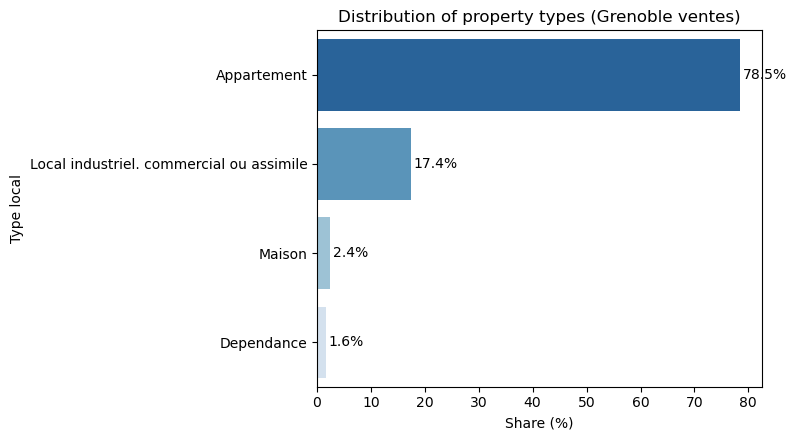

In [18]:
# Plot the ratio (percentage share) of each type_local in the dataset
import unicodedata

def _norm_label(s):
    s = '' if s is None else str(s)
    s = unicodedata.normalize('NFKD', s)
    s = ''.join(ch for ch in s if not unicodedata.combining(ch))
    return ' '.join(s.strip().split())

if 'df_grenoble_vente' in globals() and 'type_local' in df_grenoble_vente.columns:
    s = df_grenoble_vente['type_local'].map(_norm_label)
    share = (s.value_counts(normalize=True) * 100).sort_values(ascending=False)
    counts = s.value_counts().reindex(share.index)
    plot_df = pd.DataFrame({
        'type_local': share.index,
        'ratio_pct': share.values,
        'count': counts.values
    })
    display(plot_df)

    plt.figure(figsize=(8, 4.5))
    ax = sns.barplot(data=plot_df, x='ratio_pct', y='type_local', palette='Blues_r')
    ax.set_xlabel('Share (%)')
    ax.set_ylabel('Type local')
    ax.set_title('Distribution of property types (Grenoble ventes)')
    for i, v in enumerate(plot_df['ratio_pct']):
        ax.text(v + 0.5, i, f'{v:.1f}%', va='center')
    plt.tight_layout()
else:
    print('df_grenoble_vente.type_local not found; run preparation cells first.')

## 12. Détection et retrait des valeurs aberrantes (IQR) par type
Utilisation de l'intervalle interquartile (IQR) pour filtrer les valeurs extrêmes par catégorie de bien.

In [19]:
# Function to remove outliers
def remove_outliers(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    return df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

In [20]:
# Per-type outlier removal with robust type matching and safe concat/plot
df_processed_parts = []
types = ['Dépendance','Appartement', 'Local industriel. commercial ou assimilé','Maison']

import unicodedata

def _strip_accents_lower(s):
    s = '' if s is None else str(s)
    s = unicodedata.normalize('NFKD', s)
    s = ''.join(ch for ch in s if not unicodedata.combining(ch))
    return ' '.join(s.strip().lower().split())

if 'df_grenoble_vente' in globals() and isinstance(df_grenoble_vente, pd.DataFrame) and not df_grenoble_vente.empty:
    tl_norm = df_grenoble_vente.get('type_local', pd.Series([], dtype=str)).map(_strip_accents_lower)
    for t in types:
        t_norm = _strip_accents_lower(t)
        m = tl_norm.eq(t_norm)
        df_type = df_grenoble_vente.loc[m].copy()
        if df_type.empty:
            continue
        # Numeric-only for IQR based outlier filtering
        num = df_type.select_dtypes(include=[np.number])
        if num.empty:
            continue
        df_no_outliers_num = remove_outliers(num)
        if df_no_outliers_num.empty:
            continue
        # Align back to original columns using surviving indices
        df_no_outliers = df_type.loc[df_no_outliers_num.index]
        df_processed_parts.append(df_no_outliers)

    if df_processed_parts:
        df_preprocessed = pd.concat(df_processed_parts, ignore_index=True)

    else:
        print('No data after per-type outlier removal.')
        df_preprocessed = pd.DataFrame()
else:
    print('df_grenoble_vente not available or empty.')
    df_preprocessed = pd.DataFrame()

## 13. Visualisation avant / après par type
Comparaison des distributions avant et après filtrage des valeurs aberrantes, avec limites d'axe adaptées par variable.

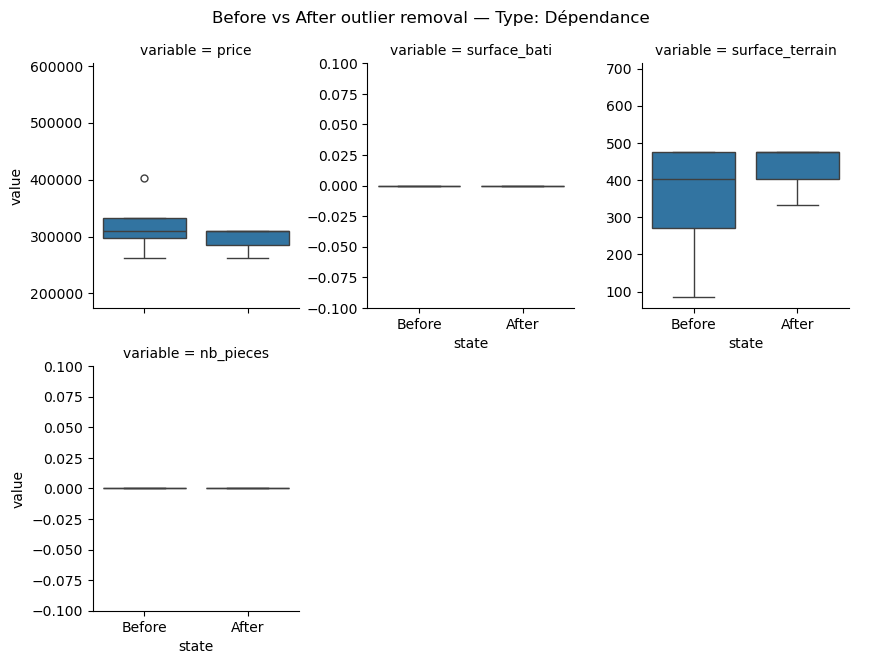

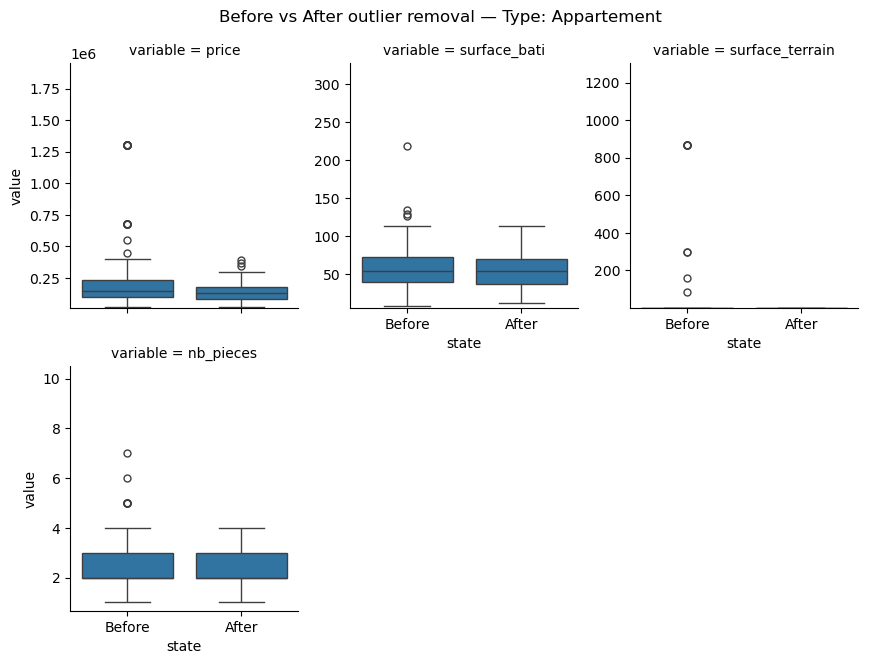

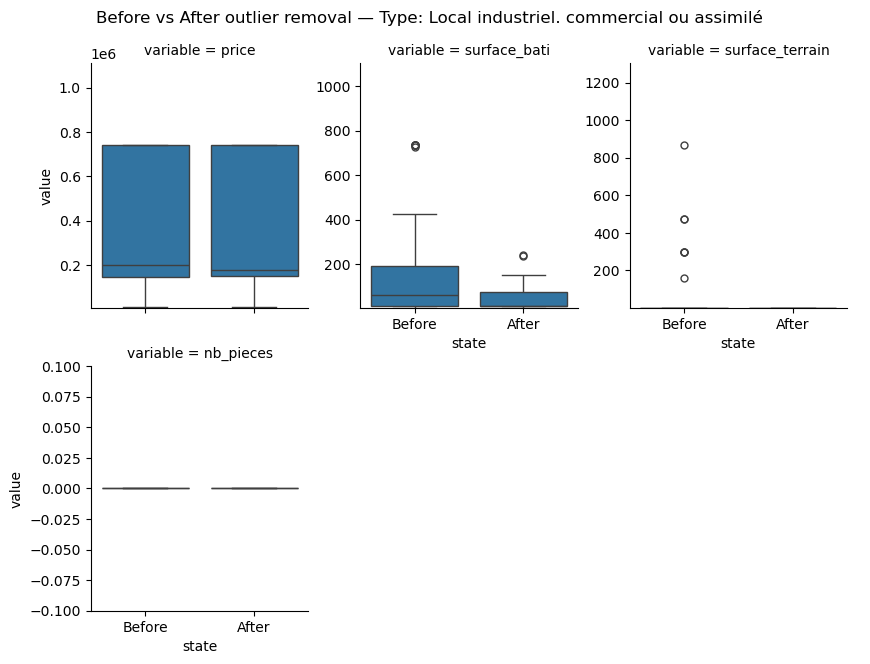

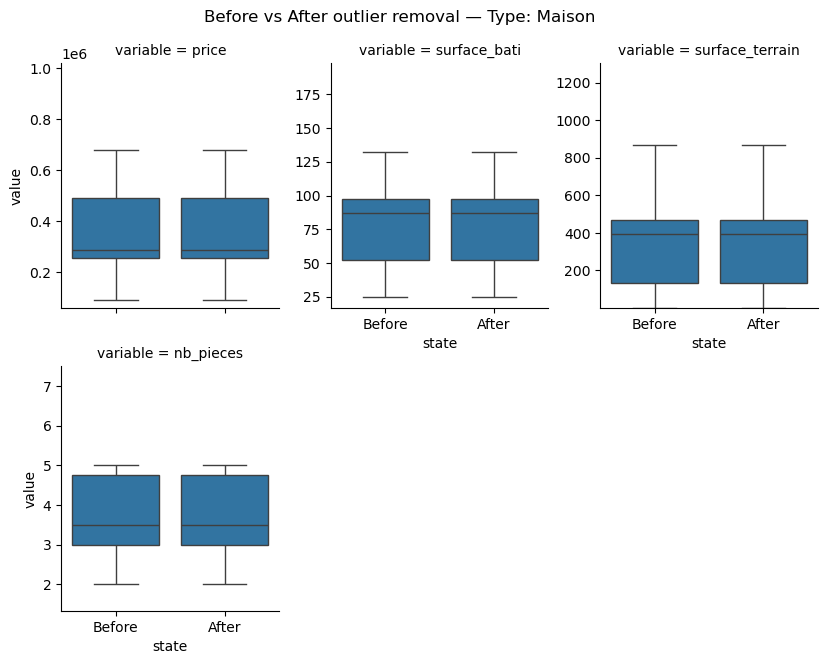

In [21]:
# Boxplot each type before vs after outlier removal, with per-variable y-lims

def _norm_type(s):
    s = '' if s is None else str(s)
    s = unicodedata.normalize('NFKD', s)
    s = ''.join(ch for ch in s if not unicodedata.combining(ch))
    return ' '.join(s.strip().lower().split())

types = ['Maison', 'Appartement', 'Local industriel. commercial ou assimilé', 'Dépendance'] if 'types' not in globals() else types

if ('df_grenoble_vente' in globals() and isinstance(df_grenoble_vente, pd.DataFrame) and not df_grenoble_vente.empty 
    and 'df_preprocessed' in globals() and isinstance(df_preprocessed, pd.DataFrame) and not df_preprocessed.empty):

    # Normalize type labels
    tl_before = df_grenoble_vente.get('type_local', pd.Series([], dtype=str)).map(_norm_type)
    tl_after  = df_preprocessed.get('type_local', pd.Series([], dtype=str)).map(_norm_type)

    # Intersection of numeric columns
    num_before = set(df_grenoble_vente.select_dtypes(include=[np.number]).columns)
    num_after  = set(df_preprocessed.select_dtypes(include=[np.number]).columns)
    numeric_cols = [c for c in df_grenoble_vente.columns if c in (num_before & num_after)]

    if not numeric_cols:
        print('No common numeric columns to plot.')
    else:
        for t in types:
            t_norm = _norm_type(t)
            m_b = tl_before.eq(t_norm)
            m_a = tl_after.eq(t_norm)

            df_b = df_grenoble_vente.loc[m_b, numeric_cols].copy()
            df_a = df_preprocessed.loc[m_a,  numeric_cols].copy()

            if df_b.empty and df_a.empty:
                print(f'No data for type: {t}')
                continue

            # Build long form
            long_b = df_b.melt(var_name='variable', value_name='value'); long_b['state'] = 'Before'
            long_a = df_a.melt(var_name='variable', value_name='value'); long_a['state'] = 'After'
            long = pd.concat([long_b, long_a], ignore_index=True).dropna(subset=['value'])

            if long.empty:
                print(f'Only NaNs for type: {t}')
                continue

            # ---- per-variable y-limits: [min/1.5, max*1.5] ----
            # (This matches “between 1.5 min and 1.5 max” while avoiding clipping when min > 0)
            ylims = {}
            for var, grp in long.groupby('variable', sort=False):
                vals = pd.to_numeric(grp['value'], errors='coerce').dropna()
                if vals.empty:
                    ylims[var] = (0.0, 1.0)
                    continue
                vmin, vmax = float(vals.min()), float(vals.max())
                if np.isfinite(vmin) and np.isfinite(vmax):
                    # Edge case: constant series
                    if vmin == vmax:
                        pad = 0.1 * (abs(vmax) if vmax != 0 else 1.0)
                        lo, hi = vmin - pad, vmax + pad
                    else:
                        lo, hi = vmin/1.5, vmax*1.5
                else:
                    lo, hi = 0.0, 1.0
                ylims[var] = (lo, hi)

            # Plot
            g = sns.catplot(
                data=long, x='state', y='value', col='variable',
                kind='box', sharey=False, col_wrap=3, height=3.2, aspect=0.9
            )
            g.fig.suptitle(f'Before vs After outlier removal — Type: {t}', y=1.03)

            # Apply per-facet y-limits
            # g.col_names aligns with axes in FacetGrid
            for ax, var in zip(np.ravel(g.axes), g.col_names):
                lo, hi = ylims.get(var, (None, None))
                if lo is not None and hi is not None:
                    ax.set_ylim(lo, hi)

            plt.show()
else:
    if 'df_grenoble_vente' not in globals() or df_grenoble_vente.empty:
        print('df_grenoble_vente not available or empty.')
    if 'df_preprocessed' not in globals() or df_preprocessed.empty:
        print('df_preprocessed not available or empty. Run the outlier-removal cell first.')


## 14. Encodage des catégories `type_local` → 1..4
Encodage fixe et reproductible: Appartement=1, Dépendance=2, Local ind./com./assimilé=3, Maison=4.

In [22]:
import unicodedata
def encode_type_local_1234(df, source_col='type_local', out_col='type_local_1234',
                           return_mapping=False):
    """
    Encode df[source_col] into fixed codes 1..4 after normalization/canonicalization.
      Mapping (fixed):
        'Appartement'                                   -> 1
        'Dépendance'                                  -> 2
        'Local industriel. commercial ou assimilé'     -> 3
        'Maison'                                       -> 4

    Unknown/unmatched -> <NA> (nullable Int64).
    Returns df_out (and label->code mapping if return_mapping=True).
    """
    if source_col not in df.columns:
        raise KeyError(f"Column '{source_col}' not found in DataFrame")

    def _normalize(s):
        s = '' if s is None else str(s)
        s = unicodedata.normalize('NFKD', s)
        s = ''.join(ch for ch in s if not unicodedata.combining(ch))
        return ' '.join(s.strip().lower().split())

    def _canonicalize(raw):
        n = _normalize(raw)
        # exact matches (normalized)
        exact = {
            'maison': 'Maison',
            'appartement': 'Appartement',
            'local industriel. commercial ou assimile': 'Local industriel. commercial ou assimilé',
            'local industriel commercial ou assimile': 'Local industriel. commercial ou assimilé',
            'dependance': 'Dépendance',
            'dépendance': 'Dépendance',  # harmless duplicate after normalize
        }
        if n in exact:
            return exact[n]
        # soft contains
        if 'appart' in n:
            return 'Appartement'
        if 'maison' in n:
            return 'Maison'
        if 'industriel' in n or 'commercial' in n or 'assimile' in n:
            return 'Local industriel. commercial ou assimilé'
        if 'depend' in n:
            return 'Dépendance'
        return None

    label_to_code = {
        'Appartement': 1,
        'Dépendance': 2,
        'Local industriel. commercial ou assimilé': 3,
        'Maison': 4,
    }

    out = df.copy()
    canon = out[source_col].map(_canonicalize)
    out[out_col] = canon.map(label_to_code).astype('Int64')

    if return_mapping:
        return out, label_to_code
    return out


In [23]:
df_grenoble_vente, m = encode_type_local_1234(df_grenoble_vente, return_mapping=True)
print(m)
df_grenoble_vente[['type_local', 'type_local_1234']].head()
df_grenoble_vente

{'Appartement': 1, 'Dépendance': 2, 'Local industriel. commercial ou assimilé': 3, 'Maison': 4}


,price,type_local,surface_bati,surface_terrain,nb_pieces,type_local_1234
0,112560.0,Appartement,45.0,1.0,2,1
1,65000.0,Appartement,29.0,1.0,1,1
2,9000.0,Local industriel. commercial ou assimilé,12.0,1.0,0,3
3,133000.0,Appartement,49.0,1.0,2,1
4,53000.0,Appartement,14.0,1.0,1,1
...,...,...,...,...,...,...
242,55000.0,Appartement,56.0,1.0,3,1
243,87170.0,Appartement,52.0,1.0,2,1
244,256900.0,Appartement,74.0,1.0,3,1
245,256500.0,Appartement,114.0,1.0,4,1


## 15. Matrice de corrélation
Aperçu des relations linéaires entre les variables numériques.

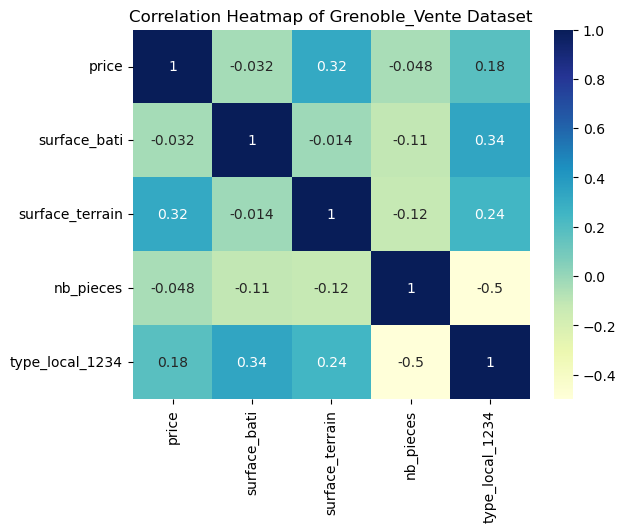

In [24]:
# Compute correlation matrix
corr = df_grenoble_vente.corr(numeric_only=True)

# Plot
sns.heatmap(corr, annot=True, cmap="YlGnBu")

plt.title("Correlation Heatmap of Grenoble_Vente Dataset")
# la correlation date/price est plus que celle entre nb_piece/price en valeur absolue donc en la garde
plt.show()


## 16. Export des jeux de données
Sauvegarde du jeu `df_grenoble_vente` nettoyé dans le dossier `PreprocessedData`.

In [25]:
# Save full Grenoble ventes and appartements-only CSVs into ./PreprocessedData next to this notebook
from pathlib import Path
import unicodedata

if 'df_grenoble_vente' in globals():
    df_out = df_grenoble_vente.copy()

    # Save into PreprocessedData folder located alongside this running file (notebook CWD)
    save_dir = Path.cwd() / 'PreprocessedData'
    save_dir.mkdir(parents=True, exist_ok=True)

    all_path = save_dir / 'df_grenoble_vente.csv'
    # Robust filter for type_local == 'appartement' (case/accents/whitespace insensitive)
    def _norm(s):
        s = '' if s is None else str(s)
        s = unicodedata.normalize('NFKD', s)
        s = ''.join(ch for ch in s if not unicodedata.combining(ch))
        return ' '.join(s.strip().lower().split())

    # Save CSVs
    df_out.to_csv(all_path, index=False)

    print(f"Saved: {all_path} (rows={len(df_out)})")
else:
    print("df_grenoble_vente not found; run the preparation cells first.")

Saved: /home/hamlil/Desktop/Etude/MIASHS/L3/S5/Econometrie/ProjetEconometrie-main/DataPreprocessing/PreprocessedData/df_grenoble_vente.csv (rows=247)


## 17. Conclusion
Le pipeline met en forme les données DVF pour Grenoble: filtrage, nettoyage, transformations temporelles, diagnostic des outliers, encodage des catégories, visualisations et export.
Les données sont prêtes pour la modélisation (ex: régression linéaire, forêts aléatoires) dans le dossier `ModelTraining`.